In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr,ttest_ind
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.metrics import RocCurveDisplay,classification_report
from sklearn.model_selection import (train_test_split,cross_validate,
    GridSearchCV,StratifiedKFold)
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.pipeline import Pipeline

import shap
from statsmodels.stats.multitest import multipletests

from collections import Counter
import ipyparallel as ipp
from contextlib import redirect_stderr
import os
from tqdm.notebook import trange,tqdm

In [2]:
%matplotlib inline
%load_ext watermark

In [3]:
# start a cluster using ipcluster start in a terminal before executing this
rc = ipp.Client()

In [4]:
# set a fixed random state for reproduceability random state from random.org
import random
random.seed(0x9e3047133e3412828a6be28778850f1d32b61c929e6859fae158ec6bce96c044b1bea5d0c60740f4800863a87a4f6775)
np.random.seed(random.randint(0, 0x1<<31))

collinear_gridsearch_rand_seed = random.getrandbits(30)
rfecv_rand_seed = random.getrandbits(30)
classification_report_rand_seed = random.getrandbits(30)
permutation_test_rand_seed = random.getrandbits(30)
shap_bootstrap_rand_seed = random.getrandbits(30)

In [5]:
data = pd.read_csv('../data/grouped-cancer-dataset.csv.xz')
data.head()

,Hugo_Symbol,Label,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,LOC149767,TIMM23,MOXD2,LOC155060,RNU12-2P,...,ZXDA,ZXDB,LOC100130182,ZYG11A,ZYG11B,ZYX,FLJ10821,ZZZ3,HUMRTVLH3,AKR1C6P
0,BA-A1-A0SO,E,0.0,12.5687,21.4958,383.9288,669.9357,0,143.0169,1.0814,...,71.6436,561.2536,374.1691,108.4117,1791.9022,1341.2231,821.0632,897.8436,444.4610,0.0
1,BA-A2-A04Q,E,0.0,1.1801,3.8334,185.5958,1706.1319,0,354.8014,0.3857,...,37.0228,298.4960,885.4609,127.2657,728.4998,4357.1153,896.6448,568.0679,26.2245,0.0
2,BA-A2-A04T,E,0.0,16.6878,23.9972,232.6558,758.0631,0,165.8698,0.3477,...,88.6725,739.2854,1018.8646,155.7854,1028.6012,3453.7077,1616.2740,655.1334,401.9821,0.0
3,BA-A2-A04U,E,0.0,0.0000,0.5195,411.4041,4388.1024,0,78.9713,0.0000,...,17.6646,174.0486,875.4384,130.4065,589.1674,3222.7562,617.7426,1264.0603,85.7254,0.0
4,BA-A2-A0D2,E,0.0,9.8281,9.3920,177.6492,1826.2798,0,164.8494,0.0000,...,41.0275,402.1438,906.6716,185.5480,1189.7986,10575.1247,743.6703,928.1094,20.3290,0.0


In [6]:
data.describe()

,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,LOC149767,TIMM23,MOXD2,LOC155060,RNU12-2P,SSX9,LOC317712,...,ZXDA,ZXDB,LOC100130182,ZYG11A,ZYG11B,ZYX,FLJ10821,ZZZ3,HUMRTVLH3,AKR1C6P
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.006105,10.639727,10.021203,155.767873,1366.055649,0.0,205.331805,0.325925,0.315184,0.220193,...,52.125130,402.859620,1046.847814,155.232602,940.979580,5177.534854,1105.346948,1012.307186,226.644723,0.293591
std,0.048845,8.697243,7.858926,78.771835,679.889290,0.0,156.563507,0.414377,2.936522,1.629687,...,24.784909,168.060015,286.459651,126.529202,384.799084,2725.627891,450.914278,411.879425,281.428133,1.590348
min,0.000000,0.000000,0.000000,61.356500,345.121200,0.0,34.621600,0.000000,0.000000,0.000000,...,8.808000,86.318300,374.169100,0.587200,340.575500,1168.611800,351.851900,244.862000,1.787200,0.000000
25%,0.000000,4.183075,4.431550,102.349100,916.759375,0.0,107.842150,0.000000,0.000000,0.000000,...,32.582350,280.131575,849.554700,57.316650,686.346175,3435.013025,803.858975,682.617675,26.109600,0.000000
50%,0.000000,9.359550,7.962300,132.494250,1298.277450,0.0,164.682750,0.235550,0.000000,0.000000,...,51.245200,385.669450,1025.292150,128.699050,845.120700,4516.313950,1014.324900,976.320850,133.203000,0.000000
75%,0.000000,15.122225,12.955500,188.186600,1684.130925,0.0,236.366800,0.582800,0.000000,0.000000,...,65.832225,505.437450,1240.338275,231.031525,1112.490650,6459.738550,1335.991700,1259.015800,296.631650,0.000000
max,0.425400,53.997100,40.253600,505.282600,4850.556400,0.0,1042.919600,1.979700,32.811300,15.767600,...,135.308300,976.134100,1741.395300,590.197400,2449.850900,23934.233700,3300.239100,2839.058500,1467.178800,17.137400


Search the data for constant columns and drop them since they contain no information.

In [7]:
constant_columns = data.columns[(data.nunique() == 1)]
data.drop(columns=constant_columns, inplace=True)
print('dropped', len(constant_columns), 'columns for being constant')

dropped 471 columns for being constant


Find columns that have most of the data represented by a single value. When these columns are used in 5-fold cross there will very likely be a single value in some of the folds. This is mostly a problem with the permutation test. The correlations of the raw data keep these columns from being selected by LIBLINEAR. Once the relationship is destroyed by the permutation they can float to the surface and cause the spearmanr code to error.

In [8]:
sparse_columns = [c for c in data.columns if np.any(data[c].value_counts(normalize=True) > 4/5)]
data.drop(columns=sparse_columns, inplace=True)
print('dropped', len(sparse_columns), 'columns for being sparse')

dropped 1333 columns for being sparse


In [9]:
print(data['Label'].value_counts())

X = data.drop(columns=['Hugo_Symbol', 'Label'])
Y = data['Label']

E    87
A    41
Name: Label, dtype: int64


In [10]:
min_data = pd.pivot_table(data, index=['Label'], aggfunc=np.min)
max_data = pd.pivot_table(data, index=['Label'], aggfunc=np.max)

np.any((min_data.loc['A'] > max_data.loc['E']) | (max_data.loc['A'] < min_data.loc['E']))

False

In [11]:
clf = Pipeline([
    ('standardize',StandardScaler()),
    ('clf', LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        verbose=True,
        max_iter=10000
    ))
])
selector = SelectFromModel(
    clf, 
    importance_getter='named_steps.clf.coef_'
)

selector.fit(X, Y)
l1_feature_names = list(selector.get_feature_names_out())

print('number of features', len(l1_feature_names))
print('Features selected:', *l1_feature_names)

[LibLinear]...........................................*.................................*...............................*...................................*.............................................*.....................................*................*......*.***.***
optimization finished, #iter = 2486
Objective value = 3.386241
#nonzeros/#features = 94/18728
number of features 92
Features selected: ADAM19 FDH AMFR FLJ20548 ATXN7L3 BRS3 DHRS4-AS1 C19ORF52 PRR34 C8ORF48 PLGRKT FIH CCDC30 CREG2 CRHR1 CROCCP2 CRYAA DDX51 DNASE1L1 ELMO3 FAM167A FAM19A4 MTFR1L FLJ26850 FOXA3 LD FOXQ1 FRG2 ADGRF2 GPR179 GPR17 GPR89B GRIA1 HEXIM1 HIP1R IMPG2 IQCK KCNE3 KDM4C KIAA1324L KLK10 KRT40 KRTAP1-5 LGR6 TEKT4P2 LOC100133331 USP32P1 LOC284379 XRCC6P5 ASH1L-AS1 GMNC POLR1A LRFN4 LRRC37A2 LRRC37A LOC199677 DFNB30 NRXN3 PAX6 CNRS5 PDE8A PGLYRP1 PIF1 PKDREJ PLA2G4C POLR1A.1 POLR2J3 PPIL3 PRKY PRSS30P TESSP5 PWP2 KBF2 RETN RFPL4 RPS26P11 NSP-CL Smc1l2 SNORA76C SRPX FLJ45737 SULT1E1 SYCP3 TMEM177 TREML4

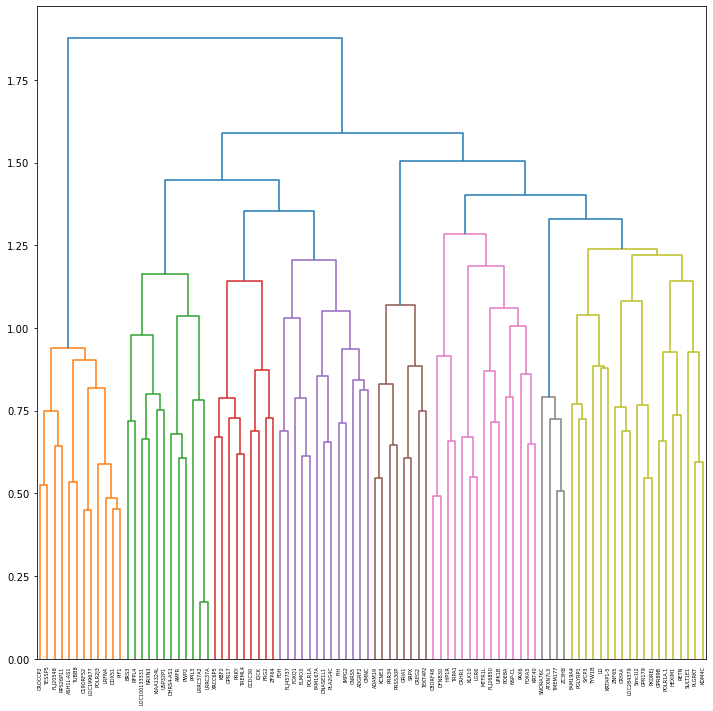

In [12]:
# borrowed directly from scikit learn docs:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
corr = spearmanr(X[l1_feature_names]).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

plt.figure(figsize=(12,12))
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=l1_feature_names, ax=plt.gca(), leaf_rotation=90
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


selected theshold 0.35
number of features selected 92
selected features: ADAM19 FDH AMFR FLJ20548 ATXN7L3 BRS3 DHRS4-AS1 C19ORF52 PRR34 C8ORF48 PLGRKT FIH CCDC30 CREG2 CRHR1 CROCCP2 CRYAA DDX51 DNASE1L1 ELMO3 FAM167A FAM19A4 MTFR1L FLJ26850 FOXA3 LD FOXQ1 FRG2 ADGRF2 GPR179 GPR17 GPR89B GRIA1 HEXIM1 HIP1R IMPG2 IQCK KCNE3 KDM4C KIAA1324L KLK10 KRT40 KRTAP1-5 LGR6 TEKT4P2 LOC100133331 USP32P1 LOC284379 XRCC6P5 ASH1L-AS1 GMNC POLR1A LRFN4 LRRC37A2 LRRC37A LOC199677 DFNB30 NRXN3 PAX6 CNRS5 PDE8A PGLYRP1 PIF1 PKDREJ PLA2G4C POLR1A.1 POLR2J3 PPIL3 PRKY PRSS30P TESSP5 PWP2 KBF2 RETN RFPL4 RPS26P11 NSP-CL Smc1l2 SNORA76C SRPX FLJ45737 SULT1E1 SYCP3 TMEM177 TREML4 TRPA1 TUBB8 TYW1B UPK1B ZC3H8 ZFP64 ZNF65


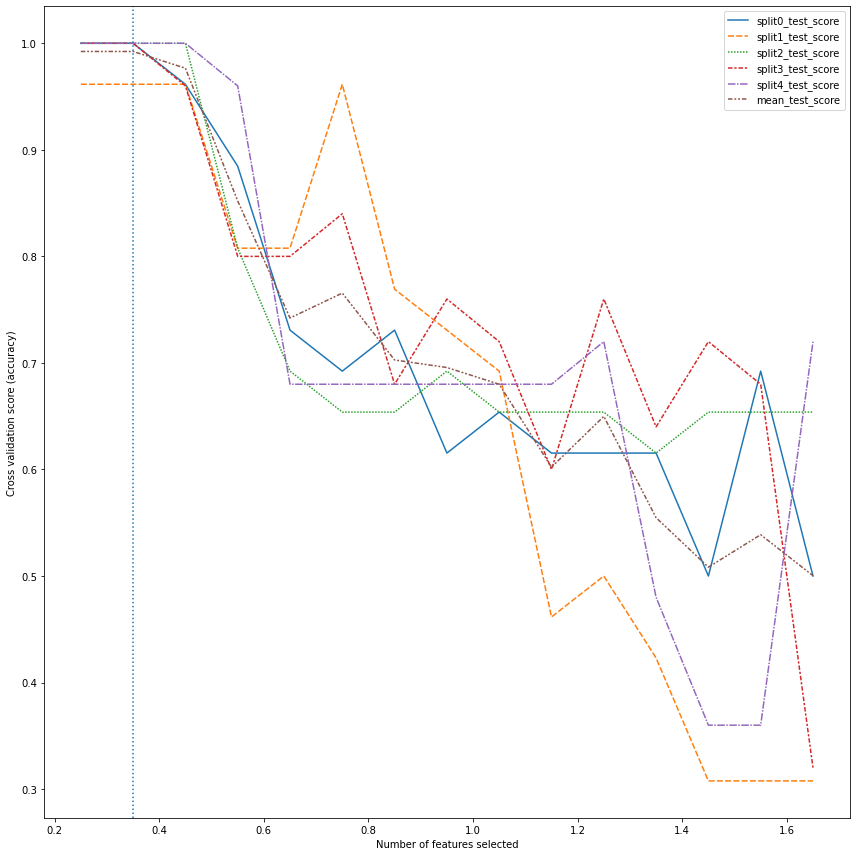

In [13]:
def drop_collinear_features(X, threshold=0):
    # borrowed directly from scikit learn docs:
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(
        squareform(
            np.nan_to_num(distance_matrix)
        )
    )
    clustering = hierarchy.fcluster(
        dist_linkage,
        t=threshold,
        criterion='distance')
    mask = np.ones(len(X.columns), bool)
    mask[np.unique(clustering, return_index=True)[1]] = 0
    return X.assign(**{ c : 0.0 for c in X.columns[mask] })

test_clf = Pipeline([
    ('drop_features', FunctionTransformer(drop_collinear_features)),
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'
    ))
])

thresholds = list(np.arange(0.25,1.75,0.1))[::-1]
search = GridSearchCV(
    test_clf,
    { 'drop_features__kw_args' : [
        { 'threshold' : v }
            for v in thresholds
    ]},
    cv=StratifiedKFold(
        random_state=collinear_gridsearch_rand_seed,
        shuffle=True
    )
)
with np.errstate(divide='ignore', invalid='ignore'):
    search.fit(X[l1_feature_names], Y)

selected_threshold = search.best_params_['drop_features__kw_args']['threshold']
print('selected theshold', selected_threshold)
ward_feature_names = drop_collinear_features(X[l1_feature_names], selected_threshold).columns
print('number of features selected', len(ward_feature_names))
print('selected features:', *ward_feature_names)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
selector_data = pd.DataFrame.from_dict(search.cv_results_)
selector_data.drop(
    columns=[
        'mean_fit_time',
        'std_fit_time',
        'mean_score_time',
        'std_score_time',
        'std_test_score',
        'rank_test_score'
    ],
    inplace=True
)
selector_data.set_index(iter(thresholds), inplace=True)

sns.lineplot(
    data=selector_data
)
plt.axvline(
    search.best_params_['drop_features__kw_args']['threshold'],
    linestyle=':',
    label='threshold chosen'
)
plt.tight_layout()
plt.savefig('../figures/gridsearchcv-line-plot.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Optimal number of features : 45
Features selected: FDH ATXN7L3 DHRS4-AS1 PLGRKT FIH CCDC30 CROCCP2 DDX51 DNASE1L1 ELMO3 FLJ26850 FOXA3 GPR17 HEXIM1 HIP1R IQCK KCNE3 KIAA1324L KLK10 XRCC6P5 POLR1A LRRC37A2 LRRC37A PAX6 PDE8A PGLYRP1 PIF1 PLA2G4C POLR1A.1 PRKY TESSP5 PWP2 KBF2 RPS26P11 SNORA76C SRPX FLJ45737 SULT1E1 TREML4 TUBB8 TYW1B UPK1B ZC3H8 ZFP64 ZNF65


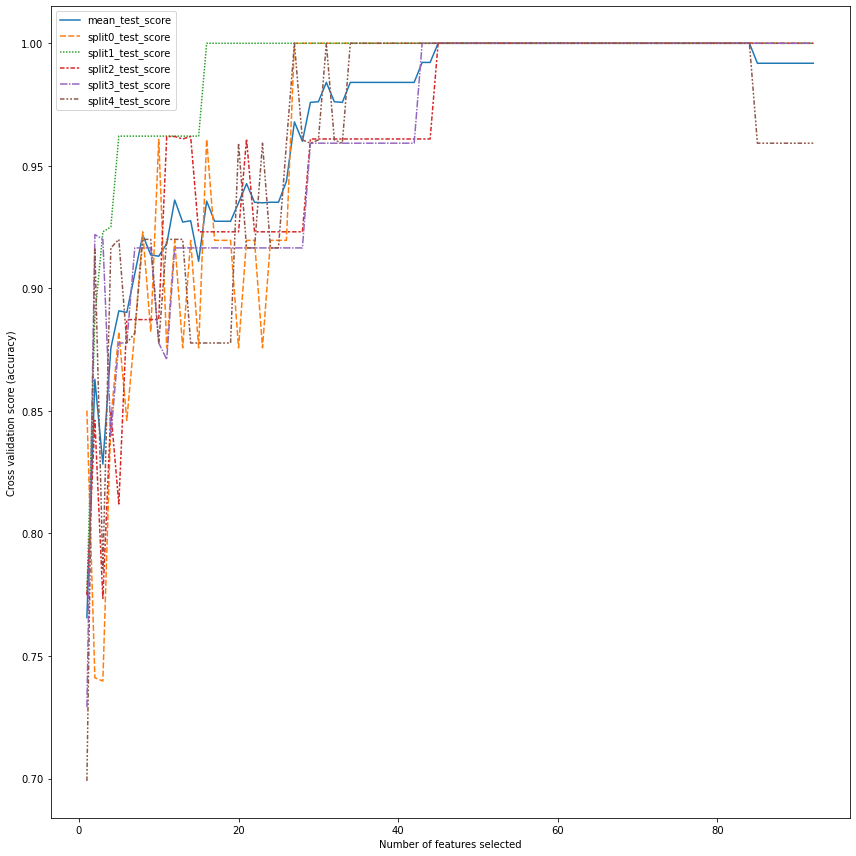

In [14]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'
    ))
])
selector = RFECV(
    test_clf,
    scoring='f1_weighted',
    importance_getter='named_steps.svc.coef_',
    cv=StratifiedKFold(random_state=rfecv_rand_seed, shuffle=True)
)
selector.fit(X[ward_feature_names], Y)
rfecv_feature_names = list(selector.get_feature_names_out())

print("Optimal number of features : %d" % selector.n_features_)
print('Features selected:', *rfecv_feature_names)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
selector_data = pd.DataFrame.from_dict(selector.cv_results_)
selector_data.set_index(np.arange(1,selector.n_features_in_+1), inplace=True)
selector_data.drop(columns='std_test_score', inplace=True)

sns.lineplot(
    data=selector_data
)
plt.tight_layout()
plt.savefig('../figures/RFECV-line-plot.eps')
plt.show()

In [15]:
feature_X_train, feature_X_test, y_train, y_test = train_test_split(
    data[rfecv_feature_names],
    Y,
    stratify=Y,
    random_state=classification_report_rand_seed
)
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True))
])
test_clf.fit(feature_X_train, y_train)
print(classification_report(
    y_test,
    test_clf.predict(feature_X_test)
))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        22

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [16]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True))
])
cross_validate(
    test_clf,
    X[rfecv_feature_names],
    Y,
    scoring=[
        'balanced_accuracy',
        'roc_auc',
        'f1_weighted'
    ]
)

{'fit_time': array([0.00482249, 0.00415802, 0.00389624, 0.00407457, 0.00404119]),
 'score_time': array([0.00437093, 0.00429106, 0.00413203, 0.00383425, 0.00440049]),
 'test_balanced_accuracy': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1., 1., 1.]),
 'test_f1_weighted': array([1., 1., 1., 1., 1.])}

In [28]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'))
])
test_clf.fit(X[rfecv_feature_names], Y)

coefficents = pd.DataFrame(
    np.abs(test_clf.named_steps.svc.coef_),
    columns=rfecv_feature_names
).T
coefficents.sort_values(0, ascending=False, inplace=True)

with rc[:].sync_imports():
    import numpy
    from scipy.stats import spearmanr
    from scipy.cluster import hierarchy
    from scipy.spatial.distance import squareform
    from sklearn.svm import LinearSVC,SVC
    from sklearn.preprocessing import StandardScaler,FunctionTransformer
    from sklearn.model_selection import GridSearchCV,StratifiedKFold
    from sklearn.feature_selection import RFECV,SelectFromModel
    from sklearn.pipeline import Pipeline
    from collections import Counter

def drop_collinear_features(X, threshold=0):
    # borrowed directly from scikit learn docs:
    # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features
    corr = spearmanr(X).correlation
    corr = (corr + corr.T) / 2
    numpy.fill_diagonal(corr, 1)

    distance_matrix = 1 - numpy.abs(corr)
    dist_linkage = hierarchy.ward(
        squareform(
            numpy.nan_to_num(distance_matrix)
        )
    )
    clustering = hierarchy.fcluster(
        dist_linkage,
        t=threshold,
        criterion='distance')
    mask = numpy.ones(len(X.columns), bool)
    mask[numpy.unique(clustering, return_index=True)[1]] = 0
    return X.assign(**{ c : 0.0 for c in X.columns[mask] })

rand_state = np.random.RandomState(permutation_test_rand_seed)
for v in rc:
    v.push({
        'rand_state' : np.random.RandomState(rand_state.randint(2**30, size=128))
    })

@ipp.require(
    Y=Y,
    X=X,
    coefficents=coefficents,
    drop_collinear_features=drop_collinear_features
)
def task(_):
    y_shuffled = Y.sample(frac=1, random_state=rand_state).reset_index(drop=True)
    clf = Pipeline([
        ('standardize',StandardScaler()),
        ('clf', LinearSVC(
            penalty='l1',
            class_weight='balanced',
            dual=False,
            max_iter=10000
        ))
    ])
    selector = SelectFromModel(
        clf, 
        importance_getter='named_steps.clf.coef_'
    )

    selector.fit(X, y_shuffled)
    test_clf = Pipeline([
        ('drop_features', FunctionTransformer(drop_collinear_features)),
        ('scaler', StandardScaler()),
        ('svc',SVC(
            class_weight='balanced',
            kernel='linear'
        ))
    ])

    search = GridSearchCV(
        test_clf,
        { 'drop_features__kw_args' : [
            { 'threshold' : v }
                for v in list(numpy.arange(0.25,1.75,0.1))[::-1]
        ]},
        cv=StratifiedKFold(
            random_state=rand_state,
            shuffle=True
        )
    )
    l1_feature_names_loc = list(selector.get_feature_names_out())
    with numpy.errstate(divide='ignore', invalid='ignore'):
        search.fit(X[l1_feature_names_loc], y_shuffled)

    ward_feature_names_loc = drop_collinear_features(
        X[l1_feature_names_loc],
        search.best_params_['drop_features__kw_args']['threshold']).columns

    test_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svc',SVC(
            class_weight='balanced',
            kernel='linear'
        ))
    ])
    selector = RFECV(
        test_clf,
        min_features_to_select=1,
        scoring='f1_weighted',
        importance_getter='named_steps.svc.coef_',
        cv=StratifiedKFold(
            random_state=rand_state,
            shuffle=True)
    )
    selector.fit(X[ward_feature_names_loc], y_shuffled)
    
    test_clf.fit(X[list(selector.get_feature_names_out())], y_shuffled)
    
    excede_count = Counter()
    for coef in numpy.ravel(numpy.abs(test_clf.named_steps.svc.coef_)):
        excede_count['total'] += 1
        excede_count.update(coefficents.index[numpy.abs(coefficents[0]) < numpy.abs(coef)])
    
    return excede_count

iterations = 5000
excede_count = Counter()

lview = rc.load_balanced_view()
lview.block = True

async_result = lview.map(task, range(iterations), block=False, ordered=False, chunksize=2)
#progress_bar(async_result)
async_result.wait_interactive()

for c in async_result:
    excede_count.update(c)

2500/2500 tasks finished after 14052 s
done


In [46]:
total = excede_count['total']
df = pd.DataFrame.from_dict(
    excede_count,
    orient='index'
)
df.sort_values(0, inplace=True)
df = ((df/total)*100).round(2)
df[0]['total'] = total
df

,0
POLR1A,0.49
CROCCP2,0.81
KBF2,3.31
SULT1E1,4.94
XRCC6P5,7.16
TUBB8,7.46
PLA2G4C,8.64
PGLYRP1,9.19
KLK10,9.21
ELMO3,10.52


In [19]:
rand_state = np.random.RandomState(seed=shap_bootstrap_rand_seed)
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear',
        probability=True,
        random_state=rand_state
    ))
])

replicates = []
for _ in trange(500, leave=False):
    feature_X_train, feature_X_test, y_train, y_test = train_test_split(
        X[rfecv_feature_names],
        Y,
        stratify=Y,
        random_state=rand_state
    )

    test_clf.fit(feature_X_train.values, y_train.values)
    with redirect_stderr(open(os.devnull, 'w')):
        explainer = shap.KernelExplainer(
            test_clf.predict_proba,
            feature_X_train
        )
        shap_values = explainer.shap_values(
            feature_X_test,
            link='logit',
            silent=True)
    replicates.append(np.abs(shap_values[1]).mean(axis=0))

  0%|          | 0/500 [00:00<?, ?it/s]

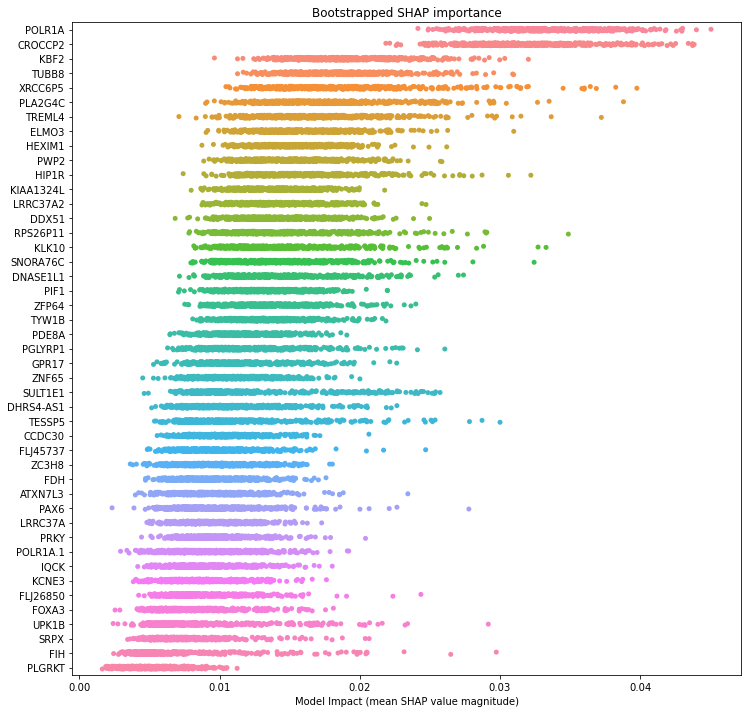

In [20]:
shap_data = pd.DataFrame(
  np.row_stack(replicates),
  columns=rfecv_feature_names
)

plt.figure(figsize=(12,12))
plt.title('Bootstrapped SHAP importance')
plt.xlabel('Model Impact (mean SHAP value magnitude)')
sns.stripplot(
    data=shap_data,
    orient='h',
    order=list(shap_data.median(axis=0).sort_values(ascending=False).index)
)
plt.savefig('../figures/bootstrap-shap-importance.eps')
plt.show()

In [50]:
test_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',SVC(
        class_weight='balanced',
        kernel='linear'))
])
test_clf.fit(X[rfecv_feature_names], Y)

pval_col_name = 'FDR'

fdr_data = multipletests(
    ttest_ind(
        X[Y == 'E'][rfecv_feature_names],
        X[Y == 'A'][rfecv_feature_names],
        axis=0
    )[1]
)
df = pd.DataFrame(
    {
        test_clf.classes_[1]+'A' : [ 'H' if coef > 0 else 'L' for coef in test_clf.named_steps.svc.coef_[0]],
        test_clf.classes_[0]+'A' : [ 'H' if coef < 0 else 'L' for coef in test_clf.named_steps.svc.coef_[0]],
        'EA means' : X[Y == 'E'][rfecv_feature_names].mean().round(2),
        'AA means' : X[Y == 'A'][rfecv_feature_names].mean().round(2),
         pval_col_name : fdr_data[1].round(3),
        'reject' : fdr_data[0]
    },
    index=rfecv_feature_names
)
df.sort_values(pval_col_name, inplace=True)
ttest_feature_names = df[df[pval_col_name] < 0.05].index
df.replace(0, value='< 0.001', inplace=True)
df

,EA,AA,EA means,AA means,FDR,reject
KBF2,H,L,746.90,525.83,< 0.001,True
TUBB8,L,H,11.01,23.60,< 0.001,True
TREML4,L,H,0.53,2.76,< 0.001,True
FLJ45737,L,H,13.35,51.86,< 0.001,True
TESSP5,L,H,1.99,10.31,< 0.001,True
CROCCP2,L,H,234.93,520.63,< 0.001,True
DDX51,L,H,411.13,721.80,< 0.001,True
LRRC37A2,H,L,125.21,61.89,< 0.001,True
POLR1A,H,L,407.11,161.32,< 0.001,True
XRCC6P5,L,H,0.74,1.98,< 0.001,True


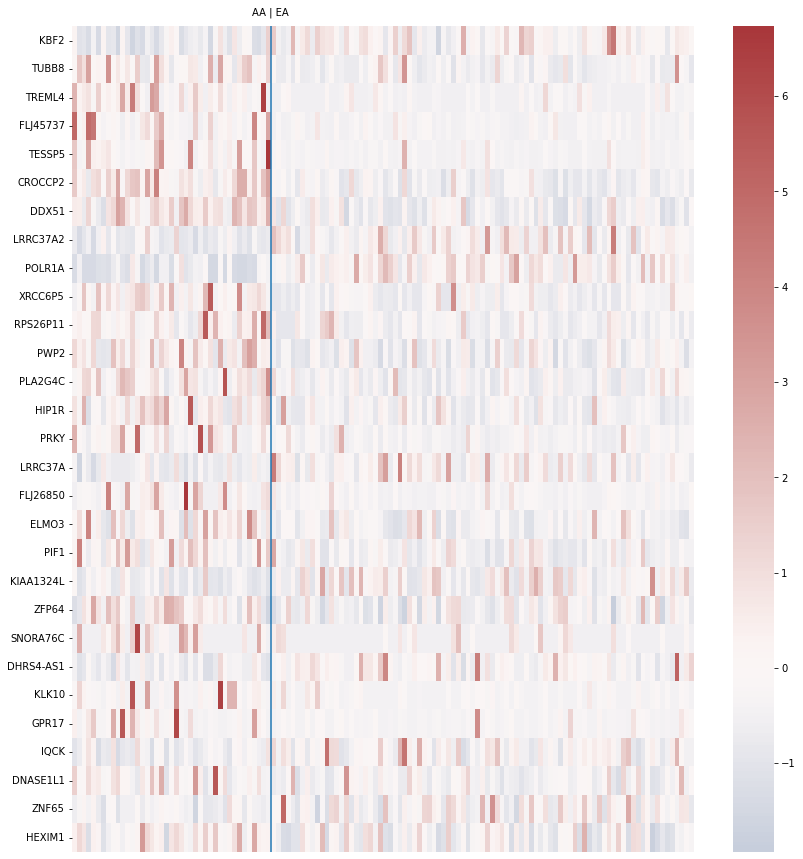

In [26]:
scaler = StandardScaler()
idx_order = np.argsort(Y)
plt.figure(figsize=(12,12))
sns.heatmap(
    data=scaler.fit_transform(data[ttest_feature_names].iloc[idx_order,:]).T,
    center=0,
    xticklabels=False,
    yticklabels=ttest_feature_names,
    cmap='vlag'
)
vline_pos = list(Y.iloc[idx_order]).index('E')
plt.axvline(vline_pos)
plt.text(vline_pos-4, -0.4, 'AA | EA')

plt.savefig('../figures/expression-heatmap.eps')
plt.tight_layout()

In [52]:
%watermark \
--python \
--packages pandas,sklearn,scipy,matplotlib,seaborn,shap \
--date --updated

Last updated: 2022-03-14

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 7.31.1

pandas    : 1.3.5
sklearn   : 1.0.2
scipy     : 1.7.3
matplotlib: 3.5.0
seaborn   : 0.11.2
shap      : 0.40.0

